In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

# Load CIFAR-10 dataset with only 100 samples per class
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ResNet-18 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

batch_size = 32
learning_rate = 0.001
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


In [2]:
class_indices = [[] for _ in range(10)]
count=0
for idx, (_, label) in enumerate(train_dataset):
    if len(class_indices[label]) < 100:
        class_indices[label].append(idx)
        count+=1
    if count==1000:
        break

In [3]:
random_seed = 42
torch.manual_seed(random_seed)

In [4]:
# from torch.utils.data.dataloader import DataLoader
# from torch.utils.data import RandomSampler

# random_seed = 42
# torch.manual_seed(random_seed)

# random_sampler =RandomSampler(train_dataset,num_samples=1000)

In [5]:
selected_indices = [idx for indices in class_indices for idx in indices]
subset_dataset = torch.utils.data.Subset(train_dataset, selected_indices)
train_loader = torch.utils.data.DataLoader(dataset=subset_dataset, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(subset_dataset))

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=random_sampler)

In [6]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

def show_batch(dl):
    count=0
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


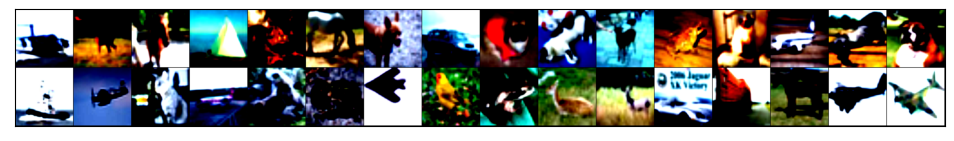

In [7]:
show_batch(train_loader)

In [13]:
# Define the ResNet-18 model
class CifarResNet18(nn.Module):
    def __init__(self):
        super(CifarResNet18, self).__init__()
        self.resnet = resnet18(pretrained=False)  # Initialize ResNet-18 without pretrained weights
        self.resnet.fc = nn.Linear(512, 10)  # Change output layer to have 10 classes

    def forward(self, x):
        return self.resnet(x)

model = CifarResNet18()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


c:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
model = model.to(device)

In [16]:
# Hyperparameters
num_epochs = 42

In [17]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if (i+1) % 10 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%')
    if accuracy==100:
        print("Model is overfit with 100% accuracy on the training dataset.")
        break

print('Training finished.')

Epoch [1/42], Average Loss: 2.2815, Train Accuracy: 20.60%
Epoch [2/42], Average Loss: 1.9475, Train Accuracy: 28.10%
Epoch [3/42], Average Loss: 1.8354, Train Accuracy: 31.90%
Epoch [4/42], Average Loss: 1.7409, Train Accuracy: 33.90%
Epoch [5/42], Average Loss: 1.7170, Train Accuracy: 37.00%
Epoch [6/42], Average Loss: 1.6754, Train Accuracy: 39.30%
Epoch [7/42], Average Loss: 1.5549, Train Accuracy: 41.80%
Epoch [8/42], Average Loss: 1.5414, Train Accuracy: 41.10%
Epoch [9/42], Average Loss: 1.4615, Train Accuracy: 44.80%
Epoch [10/42], Average Loss: 1.3484, Train Accuracy: 47.70%
Epoch [11/42], Average Loss: 1.3487, Train Accuracy: 48.70%
Epoch [12/42], Average Loss: 1.2387, Train Accuracy: 52.90%
Epoch [13/42], Average Loss: 1.1481, Train Accuracy: 57.70%
Epoch [14/42], Average Loss: 1.1062, Train Accuracy: 60.30%
Epoch [15/42], Average Loss: 1.0375, Train Accuracy: 62.30%
Epoch [16/42], Average Loss: 0.8310, Train Accuracy: 71.80%
Epoch [17/42], Average Loss: 0.7358, Train Accura

In [18]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on train images: {}%'.format(100 * correct / total))


Accuracy on train images: 100.0%


In [19]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [20]:
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

avg_loss_test = test_loss / len(test_loader)
accuracy_test = 100 * correct_test / total_test

In [21]:
print("Test accuracy: ",accuracy_test,"%", " Test Loss: ",avg_loss_test)

Test accuracy:  45.44 %  Test Loss:  2.3060142594023634


In [23]:
torch.save(model.state_dict(), 'cifar10-resnet18.pth')

In [22]:
model

CifarResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Layer: resnet.conv1.weight, Magnitude: 3.0886
torch.Size([64, 3, 7, 7])
Layer: resnet.layer1.0.conv1.weight, Magnitude: 12.0170
torch.Size([64, 64, 3, 3])
Layer: resnet.layer1.0.conv2.weight, Magnitude: 12.1430
torch.Size([64, 64, 3, 3])
Layer: resnet.layer1.1.conv1.weight, Magnitude: 12.0885
torch.Size([64, 64, 3, 3])
Layer: resnet.layer1.1.conv2.weight, Magnitude: 12.2143
torch.Size([64, 64, 3, 3])
Layer: resnet.layer2.0.conv1.weight, Magnitude: 12.5221
torch.Size([128, 64, 3, 3])
Layer: resnet.layer2.0.conv2.weight, Magnitude: 18.3291
torch.Size([128, 128, 3, 3])
Layer: resnet.layer2.1.conv1.weight, Magnitude: 18.2715
torch.Size([128, 128, 3, 3])
Layer: resnet.layer2.1.conv2.weight, Magnitude: 18.8848
torch.Size([128, 128, 3, 3])
Layer: resnet.layer3.0.conv1.weight, Magnitude: 20.9260
torch.Size([256, 128, 3, 3])
Layer: resnet.layer3.0.conv2.weight, Magnitude: 30.9876
torch.Size([256, 256, 3, 3])
Layer: resnet.layer3.1.conv1.weight, Magnitude: 30.2866
torch.Size([256, 256, 3, 3])
La

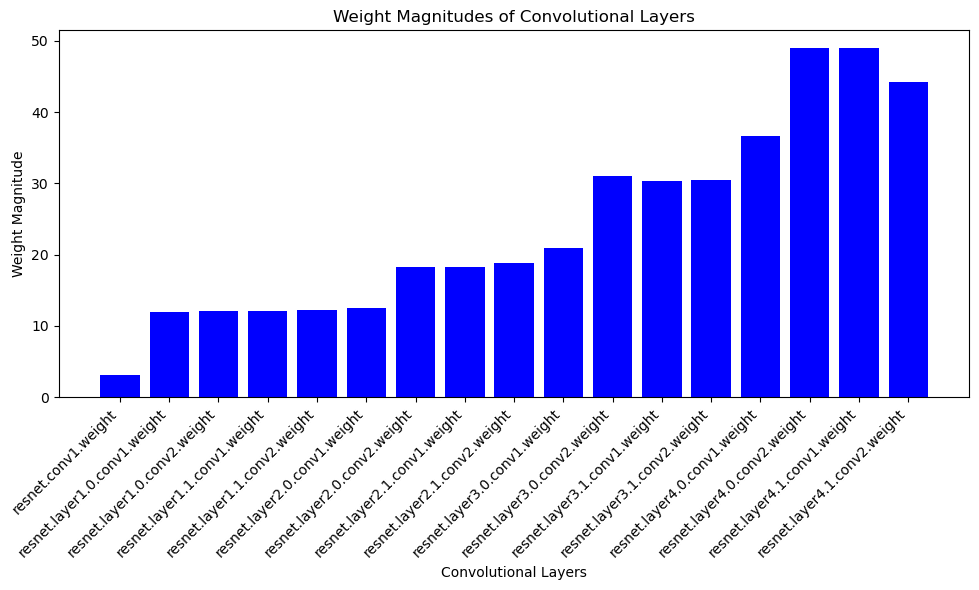

In [35]:
magnitudes = []  # To store magnitudes of weights
layer_names = []  # To store layer names

for name, param in model.named_parameters():
    if 'weight' in name and 'conv' in name:
        magnitude = torch.norm(param.data).cpu().numpy()
        print(f'Layer: {name}, Magnitude: {magnitude:.4f}')
        print(param.data.shape)
        magnitudes.append(magnitude)
        layer_names.append(name)
        # print(param.data)

plt.figure(figsize=(10, 6))
plt.bar(layer_names, magnitudes, color='blue')
plt.xlabel('Convolutional Layers')
plt.ylabel('Weight Magnitude')
plt.title('Weight Magnitudes of Convolutional Layers')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [27]:
# for name, param in model.named_parameters():
#     if 'weight' in name:
#         magnitude = torch.norm(param.data)
#         print(f'Layer: {name}, Magnitude: {magnitude:.4f}')
#         print(param.data.shape)
#         print(param.data)

Layer: resnet.conv1.weight, Magnitude: 3.0886
torch.Size([64, 3, 7, 7])
tensor([[[[-1.3603e-02,  4.0646e-03, -3.0792e-02,  ...,  2.3068e-02,
            1.2298e-02,  3.6767e-02],
          [ 2.8289e-03, -7.8530e-03, -1.7440e-02,  ..., -2.2232e-03,
           -6.2730e-03,  1.7483e-02],
          [-3.1591e-02, -6.6640e-02, -1.9213e-02,  ..., -2.4852e-02,
           -6.6763e-02,  1.1626e-04],
          ...,
          [ 3.0680e-02, -1.7976e-02, -7.4629e-03,  ..., -3.6192e-02,
           -2.4404e-02, -5.2814e-03],
          [-1.8112e-02, -1.7881e-02, -5.6646e-02,  ...,  1.4540e-02,
           -1.6301e-02,  8.4529e-03],
          [-4.5832e-02, -2.1199e-02, -4.5588e-02,  ..., -9.7886e-03,
            1.8509e-02, -3.1315e-02]],

         [[ 1.5085e-02,  3.2824e-02, -5.2572e-02,  ..., -3.2810e-02,
            1.0972e-02, -1.7018e-02],
          [ 2.2132e-02, -2.1668e-02, -1.7570e-03,  ..., -7.1964e-03,
            5.6742e-02, -5.0594e-02],
          [-3.5008e-02,  2.1592e-02, -2.1319e-02,  ...,

In [ ]:
# def visualize_weights(model):
#     for name, param in model.named_parameters():
#         if 'weight' in name and 'conv' in name:
#             plt.hist(param.data.cpu().numpy().flatten(), bins=50)
#             plt.title(name)
#             plt.show()

# # Visualize the weights
# visualize_weights(model)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weights_kernels(model, layer_idx):
    layer = model.resnet.conv1  # First convolutional layer
    if isinstance(layer, nn.Conv2d):
        weights = layer.weight.data.cpu().numpy()

        num_kernels = weights.shape[0]
        num_rows = int(np.sqrt(num_kernels))
        num_cols = int(np.ceil(num_kernels / num_rows))

        plt.figure(figsize=(10, 10))
        for idx in range(num_kernels):
            plt.subplot(num_rows, num_cols, idx + 1)
            # plt.imshow(weights[idx][0], cmap='gray')
            plt.imshow(weights[idx][0])
            plt.axis('off')
        plt.suptitle(f'Layer {layer_idx + 1}: Kernels of Convolutional Layer')
        plt.show()

In [ ]:
plot_weights_kernels(model, layer_idx=5)